In [1]:
#
# Copyright (c) 2023 salesforce.com, inc.
# All rights reserved.
# SPDX-License-Identifier: Apache-2.0
# For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/Apache-2.0
#
"""
File for running all computer vision experiments.
"""
import argparse
from collections import defaultdict
import math
import os
from re import sub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, LBFGS, SGD
import tqdm

# Our new algorithm
from online_conformal.magnitude_learner import MagnitudeLearner
from online_conformal.mag_learner_undiscounted import MagLearnUndiscounted
from online_conformal.ogd_simple import SimpleOGD

# From previous work
from online_conformal.saocp import SAOCP
from online_conformal.faci import FACI, FACI_S
from online_conformal.nex_conformal import NExConformal
from online_conformal.ogd import ScaleFreeOGD
from online_conformal.split_conformal import SplitConformal
from online_conformal.utils import pinball_loss
from cv_utils import create_model, data_loader
from cv_utils import ImageNet, TinyImageNet, CIFAR10, CIFAR100, ImageNetC, TinyImageNetC, CIFAR10C, CIFAR100C

/home/davidbombara/Documents/discounted-adaptive/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
__file__ = "vision.ipynb"

In [3]:

corruptions = [
    None,
    "brightness",
    "contrast",
    "defocus_blur",
    "elastic_transform",
    "fog",
    "frost",
    "gaussian_noise",
    "glass_blur",
    "impulse_noise",
    "jpeg_compression",
    "motion_blur",
    "pixelate",
    "shot_noise",
    "snow",
    "zoom_blur",
]

def parse_args():
    args = argparse.Namespace
    args.dataset = "TinyImageNet"
    args.model = "resnet50"
    args.lr = 1e-3
    args.batch_size = 256
    args.n_epochs = 150 #default = 150
    args.patience = 10
    #args.ignore_checkpoint = "store_true"
    args.target_cov = 90
    args.ignore_checkpoint = True

    assert 50 < args.target_cov < 100
    args.target_cov = args.target_cov / 100

    # Set up distributed training if desired, and set the device
    args.local_rank = int(os.environ.get("LOCAL_RANK", -1))
    print("args_local_rank = ", args.local_rank)
    if args.local_rank == -1:
        if torch.cuda.is_available():
            args.device = torch.device("cuda")
        else:
            args.device = torch.device("cpu")
        args.world_size = 1
    else:
        dist.init_process_group(backend="nccl")
        args.device = torch.device(args.local_rank)
        args.world_size = dist.get_world_size()
    print("args.devices = ", args.device)
        
    return args

parse_args()

args_local_rank =  -1
args.devices =  cuda


argparse.Namespace

In [4]:
def get_base_dataset(dataset, split):
    if dataset == "ImageNet":
        return ImageNet(split)
    elif dataset == "TinyImageNet":
        return TinyImageNet(split)
    elif dataset == "CIFAR10":
        return CIFAR10(split)
    elif dataset == "CIFAR100":
        return CIFAR100(split)
    raise ValueError(f"Dataset {dataset} is not supported.")


def get_model_file(args):
    rootdir = os.path.dirname(os.path.abspath(__file__))
    return os.path.join(rootdir, "cv_models", args.dataset, args.model, "model.pt")


def get_model(args):
    if args.dataset != "ImageNet":
        return torch.load(get_model_file(args), map_location=args.device)
    return create_model(dataset=ImageNet("valid"), model_name=args.model, device=args.device)


def get_results_file(args, corruption, severity):
    rootdir = os.path.dirname(os.path.abspath(__file__))
    return os.path.join(rootdir, "cv_logits", args.dataset, args.model, f"{corruption}_{severity}.pt")


def get_temp_file(args):
    return os.path.join(os.path.dirname(get_results_file(args, None, 0)), "temp.txt")


def finished(args):
    for corruption in corruptions:
        for severity in [0] if corruption is None else [1, 2, 3, 4, 5]:
            fname = get_results_file(args, corruption, severity)
            if not os.path.isfile(fname):
                return False
    return os.path.isfile(get_temp_file(args))


def raps_params(dataset):
    if dataset == "CIFAR10":
        lmbda, k_reg, n_class = 0.1, 1, 10
    elif dataset == "CIFAR100":
        lmbda, k_reg, n_class = 0.02, 5, 100
    elif dataset == "TinyImageNet":
        lmbda, k_reg, n_class = 0.01, 20, 200
    elif dataset == "ImageNet":
        lmbda, k_reg, n_class = 0.01, 10, 1000
    else:
        raise ValueError(f"Unsupported dataset {dataset}")
    return lmbda, k_reg, n_class


def temperature_scaling(args):
    temp = nn.Parameter(torch.tensor(1.0, device=args.device))
    opt = LBFGS([temp], lr=0.01, max_iter=500)
    loss_fn = nn.CrossEntropyLoss()

    n_epochs = 10
    valid_data = get_base_dataset(args.dataset, "valid")
    model = get_model(args)
    for epoch in range(n_epochs):
        valid_loader = data_loader(valid_data, batch_size=args.batch_size, epoch=epoch)
        for x, y in tqdm.tqdm(valid_loader, desc=f"Calibration epoch {epoch + 1:2}/{n_epochs}", disable=False):
            with torch.no_grad():
                logits = model(x.to(device=args.device))

            def eval():
                opt.zero_grad()
                loss = loss_fn(logits / temp, y.to(device=args.device))
                loss.backward()
                return loss

            opt.step(eval)

    return temp.item()


def get_logits(args):
    if args.dataset == "CIFAR10":
        dataset_cls = CIFAR10C
    elif args.dataset == "CIFAR100":
        dataset_cls = CIFAR100C
    elif args.dataset == "TinyImageNet":
        dataset_cls = TinyImageNetC
    elif args.dataset == "ImageNet":
        dataset_cls = ImageNetC
    else:
        raise ValueError(f"Dataset {args.dataset} is not supported.")
    model = None
    print("Dataset: ", dataset_cls)

    print("Applying corruptions: ", corruptions)
    for corruption in tqdm.tqdm(corruptions, desc="Corruptions", position=1):
        print("Corruption: ", corruption)
        severities = [0] if corruption is None else [1, 2, 3, 4, 5]
        print("Applying various severity levels: ", severities)
        for severity in tqdm.tqdm(severities, desc="Severity Levels", position=2, leave=False):
            print("Severity: ", severity)
            fname = get_results_file(args, corruption, severity)
            if os.path.isfile(fname) and not args.ignore_checkpoint:
                continue
            os.makedirs(os.path.dirname(fname), exist_ok=True)
            if model is None:
                model = get_model(args)

            # Save the model's logits & labels for the whole dataset
            print("Save the model's logits & labels for the whole dataset")
            logits, labels = [], []
            dataset = dataset_cls(corruption=corruption, severity=severity)
            loader = data_loader(dataset, batch_size=args.batch_size)
            with torch.no_grad():
                for x, y in loader:
                    logits.append(model(x.to(device=args.device)).cpu())
                    labels.append(y.cpu())
            torch.save([torch.cat(logits), torch.cat(labels)], fname)


def t_to_sev(t, window, run_length=500, schedule=None):
    if t < window or schedule in [None, "None", "none"]:
        return 0
    t_base = t - window // 2
    if schedule == "gradual":
        k = (t_base // run_length) % 10
        return k if k <= 5 else 10 - k
    if schedule == "random_sudden":
        #return np.random.randint(0, 5) * ((t_base // run_length) % 2)
        return np.clip(np.random.randint(0, 10) * ((t_base // run_length) % 2),0,5)
    if schedule == "random_gradual":
        k = (((t_base* abs(np.random.uniform(1,1.5))) // run_length) % 10 ) 
        return (k if k <= 5 else 10 - k) * np.random.randint(1,2) 
    return 5 * ((t_base // run_length) % 2) # default: sudden schedule

args_local_rank =  -1
args.devices =  cuda
Getting temp file...
Done
Load the saved logits


Initialize conformal prediction methods, along with accumulators for results
[]


100%|██████████| 7012/7012 [00:33<00:00, 210.21it/s]


Distribution shift: sudden
SplitConformal : Cov: 0.843, Avg Width: 129.5, Avg Miscov: 0.122, Avg Regret: 0.0077, Runtime:
NExConformal   : Cov: 0.894, Avg Width: 123.7, Avg Miscov: 0.051, Avg Regret: 0.0031, Runtime:
FACI           : Cov: 0.891, Avg Width: 123.4, Avg Miscov: 0.046, Avg Regret: 0.0030, Runtime:
ScaleFreeOGD   : Cov: 0.899, Avg Width: 123.7, Avg Miscov: 0.038, Avg Regret: 0.0031, Runtime:
SimpleOGD      : Cov: 0.899, Avg Width: 125.0, Avg Miscov: 0.041, Avg Regret: 0.0031, Runtime:
FACI_S         : Cov: 0.896, Avg Width: 124.9, Avg Miscov: 0.044, Avg Regret: 0.0030, Runtime:
SAOCP          : Cov: 0.887, Avg Width: 119.9, Avg Miscov: 0.040, Avg Regret: 0.0035, Runtime:
MagnitudeLearner: Cov: 0.901, Avg Width: 143.2, Avg Miscov: 0.034, Avg Regret: 0.0191, Runtime:
MagLearnUndiscounted: Cov: 0.894, Avg Width: 122.0, Avg Miscov: 0.044, Avg Regret: 0.0034, Runtime:
[]


100%|██████████| 7012/7012 [00:33<00:00, 206.52it/s]


Distribution shift: gradual
SplitConformal : Cov: 0.826, Avg Width: 153.1, Avg Miscov: 0.102, Avg Regret: 0.0045, Runtime:
NExConformal   : Cov: 0.895, Avg Width: 159.7, Avg Miscov: 0.041, Avg Regret: 0.0012, Runtime:
FACI           : Cov: 0.896, Avg Width: 160.3, Avg Miscov: 0.042, Avg Regret: 0.0012, Runtime:
ScaleFreeOGD   : Cov: 0.900, Avg Width: 160.5, Avg Miscov: 0.025, Avg Regret: 0.0018, Runtime:
SimpleOGD      : Cov: 0.900, Avg Width: 161.8, Avg Miscov: 0.026, Avg Regret: 0.0018, Runtime:
FACI_S         : Cov: 0.898, Avg Width: 160.6, Avg Miscov: 0.038, Avg Regret: 0.0013, Runtime:
SAOCP          : Cov: 0.881, Avg Width: 158.0, Avg Miscov: 0.035, Avg Regret: 0.0025, Runtime:
MagnitudeLearner: Cov: 0.894, Avg Width: 166.0, Avg Miscov: 0.036, Avg Regret: 0.0209, Runtime:
MagLearnUndiscounted: Cov: 0.897, Avg Width: 160.8, Avg Miscov: 0.034, Avg Regret: 0.0022, Runtime:


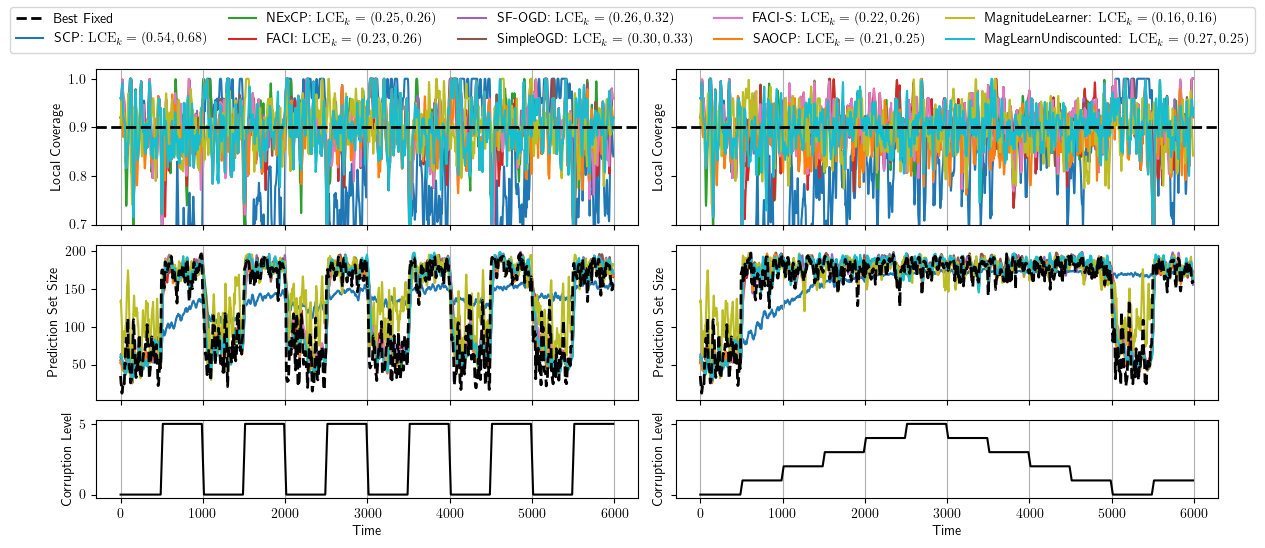

In [5]:

args = parse_args()
if args.local_rank in [-1, 0]:
    print("Getting temp file...")
    temp_file = get_temp_file(args)
    print("Done")
    if not finished(args):
        print("get_logits(args)")
        get_logits(args)
        print("...Done")
        temp = temperature_scaling(args)
        with open(temp_file, "w") as f:
            f.write(str(temp))

    # Load the saved logits
    print("Load the saved logits")
    with open(temp_file) as f:
        temp = float(f.readline())
    n_data = None
    sev2results = defaultdict(list)
    for corruption in corruptions:
        severities = [0] if corruption is None else [1, 2, 3, 4, 5]
        for severity in severities:
            try:
                logits, labels = torch.load(get_results_file(args, corruption, severity))
            except:
                continue
            sev2results[severity].append(list(zip(F.softmax(logits / temp, dim=-1).numpy(), labels.numpy())))
            n_data = len(labels) if n_data is None else min(n_data, len(labels))

    # Initialize conformal prediction methods, along with accumulators for results
    print("Initialize conformal prediction methods, along with accumulators for results")
    lmbda, k_reg, n_class = raps_params(args.dataset)
    D_old = 1 + lmbda * np.sqrt(n_class - k_reg)
    D = D_old
    methods = [SplitConformal, NExConformal, FACI, ScaleFreeOGD, SimpleOGD, FACI_S, SAOCP, MagnitudeLearner, MagLearnUndiscounted]
    #methods = [ScaleFreeOGD, SimpleOGD, MagnitudeLearner, MagLearnUndiscounted]
    label2err = defaultdict(list)
    plt.rcParams["text.usetex"] = True
    h = 5 + 0.5 * (len(methods) > 5)
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex="col", sharey="row", figsize=(12, h), height_ratios=[4, 4, 2])
    np.random.seed(0)
    for i_shift, shift in enumerate(["sudden", "gradual"]):
        sevs, s_opts, w_opts = [], [], []
        # warmup, window, run_length = 1000, 100, 500 # original code
        warmup, window, run_length = 1000, 25, 1000 # our code
        state = np.random.RandomState(0)
        order = state.permutation(n_data)[: 6 * run_length + window // 2 + warmup]
        coverages, s_hats, widths = [{m.__name__: [] for m in methods} for _ in range(3)]
        predictors = [m(None, None, max_scale = D, lifetime = 32, coverage = args.target_cov) for m in methods]
        t_vec = np.zeros(len(order))
        for t, i in tqdm.tqdm(enumerate(order, start=-warmup), total=len(order)):
            sev = t_to_sev(t, window=window, schedule = shift)
            probs, label = sev2results[sev][state.randint(0, len(sev2results[sev]))][i]

            # Convert probability to APS score
            i_sort = np.flip(np.argsort(probs))
            p_sort_cumsum = np.cumsum(probs[i_sort]) - state.rand() * probs[i_sort]
            s_sort_cumsum = p_sort_cumsum + lmbda * np.sqrt(np.cumsum([i > k_reg for i in range(n_class)]))
            w_opt = np.argsort(i_sort)[label] + 1
            s_opt = s_sort_cumsum[w_opt - 1]
            if t >= 0:
                sevs.append(sev)
                s_opts.append(s_opt)
                w_opts.append(w_opt)
                t_vec[t] = t

            # Update all the conformal predictors
            for predictor in predictors:
                name = type(predictor).__name__
                if t >= 0:
                    _, s_hat = predictor.predict(horizon=1)
                    w = np.sum(s_sort_cumsum <= s_hat)
                    s_hats[name].append(s_hat)
                    widths[name].append(w)
                    coverages[name].append(w >= w_opt)
                predictor.update(ground_truth=pd.Series([s_opt]), forecast=pd.Series([0]), horizon=1)

        # Perform evaluation & produce a pretty graph
        plot_loss = False
        for ax in axs[:, i_shift]:
            ax.xaxis.grid(True)
            ax.tick_params(axis="both", which="both", labelsize=10)

        ax1, ax2, ax3 = axs[:, i_shift]
        sevs = pd.Series(sevs).rolling(window).mean().dropna()
        w_opts = pd.Series(s_opts if plot_loss else w_opts).rolling(window).quantile(args.target_cov).dropna()
        ax1.set_ylabel("Local Coverage", fontsize=10)
        ax2.set_ylabel("Prediction Set Size", fontsize=10)
        ax3.set_xlabel("Time", fontsize=10)
        ax3.set_ylabel("Corruption Level", fontsize=10)
        ax1.axhline(args.target_cov, c="k", ls="--", lw=2, zorder=len(methods), label="Best Fixed")
        ax2.plot(np.arange(len(w_opts)), gaussian_filter1d(w_opts, sigma=2), c="k", ls="--", lw=2, zorder=len(methods))
        ax3.plot(np.arange(len(sevs)), sevs, c="k")

        s_opts = np.asarray(s_opts)
        int_q = pd.Series(s_opts).rolling(window).quantile(args.target_cov).dropna()
        print(f"Distribution shift: {shift}")
        for i, m in enumerate(methods):
            # Compute various summary statistics
            name = m.__name__ # name of the method (OGD, SAOCP, etc.)
            label = sub("Split", "S", sub("Conformal", "CP", sub("ScaleFree", "SF-", sub("_", "-", name))))
            s_hat = np.asarray(s_hats[name])
            int_cov = gaussian_filter1d(pd.Series(coverages[name]).rolling(window).mean().dropna(), sigma=3)
            int_w = pd.Series(s_hats[name] if plot_loss else widths[name]).rolling(window).mean().dropna()
            int_losses = pd.Series(pinball_loss(s_opts, s_hat, args.target_cov)).rolling(window).mean().dropna()
            opts = [pinball_loss(s_opts[i : i + window], q, args.target_cov).mean() for i, q in enumerate(int_q)]
            int_regret = int_losses.values - np.asarray(opts)
            int_miscov = np.abs(args.target_cov - int_cov)

            # Do the plotting
            color = "C" + str(i + (i > 0) if m is not SAOCP else 1)
            label2err[label].append(f"{np.max(int_miscov):.2f}")
            ax1.plot(range(len(int_cov)), int_cov, zorder=i, label=label, color=color)
            ax2.plot(range(len(int_w)), gaussian_filter1d(int_w, sigma=2), zorder=i, label=label, color=color)
            if min(int_cov) < args.target_cov - 0.2:
                ax1.set_ylim(args.target_cov - 0.2, 1.02)

            print(
                f"{name:15}: "
                f"Cov: {np.mean(coverages[name]):.3f}, "
                f"Avg Width: {np.mean(widths[name]):.1f}, "
                f"Avg Miscov: {np.mean(int_miscov):.3f}, "
                f"Avg Regret: {np.mean(int_regret):.4f}, "
                f"Runtime:"
            )

    fig.tight_layout()
    labels = []
    lines = axs[0, 0].get_lines()
    for line in lines:
        label = line.get_label()
        if label in label2err:
            label = f"{label}: $\\mathrm{{LCE}}_k = ({','.join(label2err[label])})$"
        labels.append(label)
    ncols = math.ceil(len(lines) / 2) if FACI_S in methods else len(lines)
    fig.subplots_adjust(top=0.92 if ncols == len(lines) else 0.88)
    fig.legend(lines, labels, loc="upper center", ncols=ncols, fontsize=10, columnspacing=1.5)
    figdir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "figures")
    os.makedirs(figdir, exist_ok=True)
    fig.savefig(os.path.join(figdir, f"{args.dataset}_{round(D/D_old,3)}D.pdf"))